In [38]:
# install package
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy
from IPython.display import clear_output

%matplotlib notebook

In [44]:
###### 画像 ######
path = "images_phone/05.png"
origin_img = cv2.imread(path)

In [40]:
###### 変数 ######
# コートサイズ設定
width = 1800 #コート横
height = 900 #コート縦

# コート四隅
cp_origin = [] #画像内座標配列
cp_trans = [[0,0], [0, height], [width, height], [width, 0]] #射影座標配列

# キャリブレーション物体
calib1 = [0, 0, 1] #キャリブレーション1画像内座標
calib2 = [0, 0, 1] #キャリブレーション2画像内座標

# ペンをコート中央に立てる場合、[0, 0, 140]=>[900, 0, 140], [0, 900, 140]=>[900, 900, 140]に変更する
real_calib1 = [0, 0, 140] #既知キャリブレーション1世界座標
real_calib2 = [0, 900, 140] #既知キャリブレーション2世界座標

#注目点
focus1 = [0, 0, 1]
focus2 = [0, 0, 1]

mode = "neutral" #処理モード管理変数

###### 関数 ######
def print_coord(): # 座標表示関数
    print("cp_origin", cp_origin)
    print("calib1", calib1)
    print("calib2", calib2)

def click_L(x, y): # 座標保存関数
    global cp_origin, calib1, calib2, mode
    if mode == "neutral":
        return
    elif mode == "calib1":
        calib1 = [x, y, 1]
    elif mode == "calib2":
        calib2 = [x, y, 1]
    elif mode == "focus1":
        focus1 = [x, y, 1]
    elif mode == "focus2":
        focus2 = [x, y, 1]
    else:
        cp_origin.append([x, y])
    print(x, y)

def click_R(): # 座標リセット関数
    global cp_origin, calib1, calib2, mode
    if mode == "neutral":
        return
    elif mode == "calib1":
        calib1 = [0, 0, 1]
    elif mode == "calib2":
        calib2 = [0, 0, 1]
    elif mode == "focus1":
        focus1 = [0, 0, 1]
    elif mode == "focus2":
        focus2 = [0, 0, 1]
    else:
        cp_origin = []
    print(mode, "reset")

def process(event, x, y, flags, params): # マウス割り当て関数
    if event == cv2.EVENT_LBUTTONDOWN:
        click_L(x, y)
    elif event == cv2.EVENT_RBUTTONDOWN:
        click_R()

# 射影行列計算関数
def trans_matrix(cp_origin, cp_trans):
    cp_origin = np.float32(cp_origin) # 型変換
    cp_trans = np.float32(cp_trans) # 型変換
    Matrix1 = cv2.getPerspectiveTransform(cp_origin, cp_trans) # 射影行列
    return Matrix1

# 射影先計算関数
def trans_point(Matrix, point):
    trans_point = np.dot(Matrix, point)
    trans_point /= trans_point[2]
    trans_point[2] = 0
    return trans_point

# カメラ座標計算関数
def camera(Matrix1, calib1, calib2, is_graph):
    # 射影先座標の計算
    trans_calib1 = trans_point(Matrix1, calib1)
    trans_calib2 = trans_point(Matrix1, calib2)
    
    # ベクトルの定義
    dir1 = real_calib1 - trans_calib1
    dir2 = real_calib2 - trans_calib2
    
    # 媒介変数
    t = sympy.Symbol("t") # キャリブレーション1側
    s = sympy.Symbol("s") # キャリブレーション2側
    
    # XYZの差の二乗をとった距離関数
    R = ((trans_calib1[0]+t*dir1[0]) - (trans_calib2[0]+s*dir2[0]))**2 + ((trans_calib1[1]+t*dir1[1]) - (trans_calib2[1]+s*dir2[1]))**2 + ((trans_calib1[2]+t*dir1[2]) - (trans_calib2[2]+s*dir2[2]))**2
    
    # 偏微分
    dR_dt = sympy.diff(R, t)
    dR_ds = sympy.diff(R, s)
    
    # 極値問題として解く（極大が存在しないため実質的に極小を求める）
    ans = sympy.solve([dR_dt, dR_ds])
    t_val = ans[t]
    s_val = ans[s]
    result = ((trans_calib1[0]+t_val*dir1[0]) - (trans_calib2[0]+s_val*dir2[0]))**2 + ((trans_calib1[1]+t_val*dir1[1]) - (trans_calib2[1]+s_val*dir2[1]))**2 + ((trans_calib1[2]+t_val*dir1[2]) - (trans_calib2[2]+s_val*dir2[2]))**2
    print("R", result)
    # 2直線上の最近点
    close1 = np.float32([trans_calib1[0]+t_val*dir1[0], trans_calib1[1]+t_val*dir1[1], trans_calib1[2]+t_val*dir1[2]])
    close2 = np.float32([trans_calib2[0]+s_val*dir2[0], trans_calib2[1]+s_val*dir2[1], trans_calib2[2]+s_val*dir2[2]])
    
    # カメラ位置
    camera = (close1+close2)/2
    
    # グラフ描画(オプション)
    if is_graph:
        points = 10
        # 直線1
        line1_x = [trans_calib1[0]+i*dir1[0] for i in range(points)]
        line1_y = [trans_calib1[1]+i*dir1[1] for i in range(points)]
        line1_z = [trans_calib1[2]+i*dir1[2] for i in range(points)]
        # 直線2
        line2_x = [trans_calib2[0]+i*dir2[0] for i in range(points)]
        line2_y = [trans_calib2[1]+i*dir2[1] for i in range(points)]
        line2_z = [trans_calib2[2]+i*dir2[2] for i in range(points)]
        # プロット
        fig = plt.figure()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        ax.plot(line1_x, line1_y, line1_z, "o-", color="Blue")
        ax.plot(line2_x, line2_y, line2_z, "o-", color="Red")
        ax.plot(camera[0], camera[1], camera[2], "-o", color="Black")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()

    return camera

In [47]:
###### クリック処理 ######
mode = "neutral"
cv2.imshow("Calibration", origin_img)
cv2.setMouseCallback("Calibration", process)
while True:
    key = cv2.waitKey(0) & 0xff
    clear_output(True)
    if key == ord("a"):
        mode = "court"
    elif key == ord("b"):
        mode = "calib1"
    elif key == ord("c"):
        mode = "calib2"
    elif key == ord("d"):
        mode = "focus1"
    elif key == ord("e"):
        mode = "focus2"
    elif key == ord("z"):
        clear_output(True)
        break
    print(mode)
cv2.destroyAllWindows()
print_coord()

cp_origin [[115, 750], [968, 893], [1017, 379], [640, 358]]
calib1 [89, 634, 1]
calib2 [983, 759, 1]


R 235.493972787156


<IPython.core.display.Javascript object>


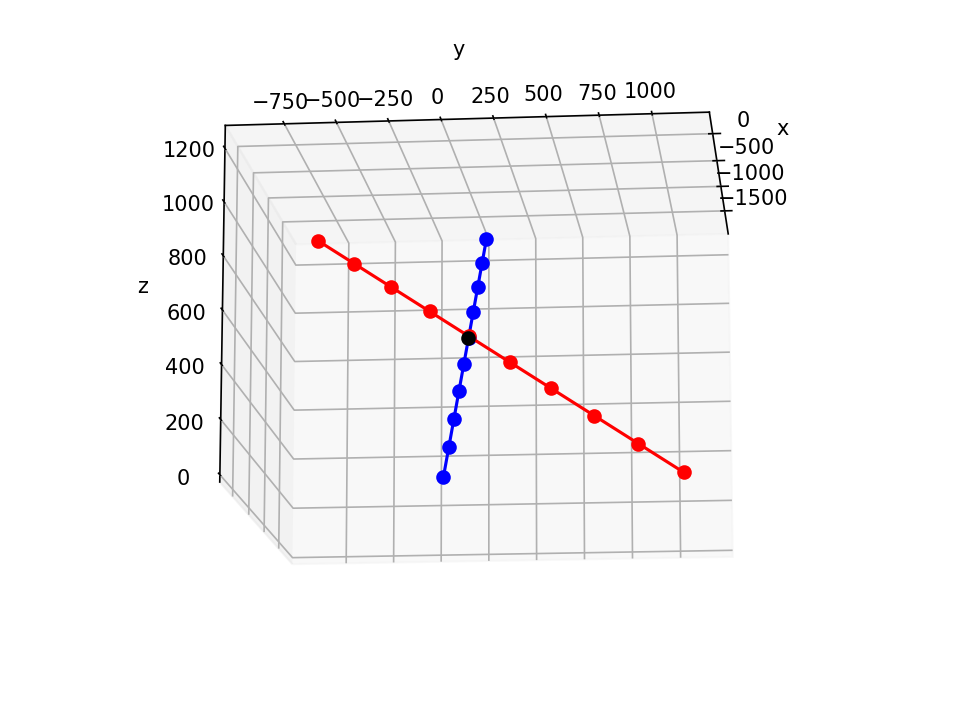

camera1 [-9.0065808e+02  8.7360400e-01  6.9683813e+02]


In [43]:
# カメラ1
Matrix1 = trans_matrix(cp_origin, cp_trans)
camera1 = camera(Matrix1, calib1, calib2, True)
print("camera1", camera1)

R 53.2593589514800


<IPython.core.display.Javascript object>


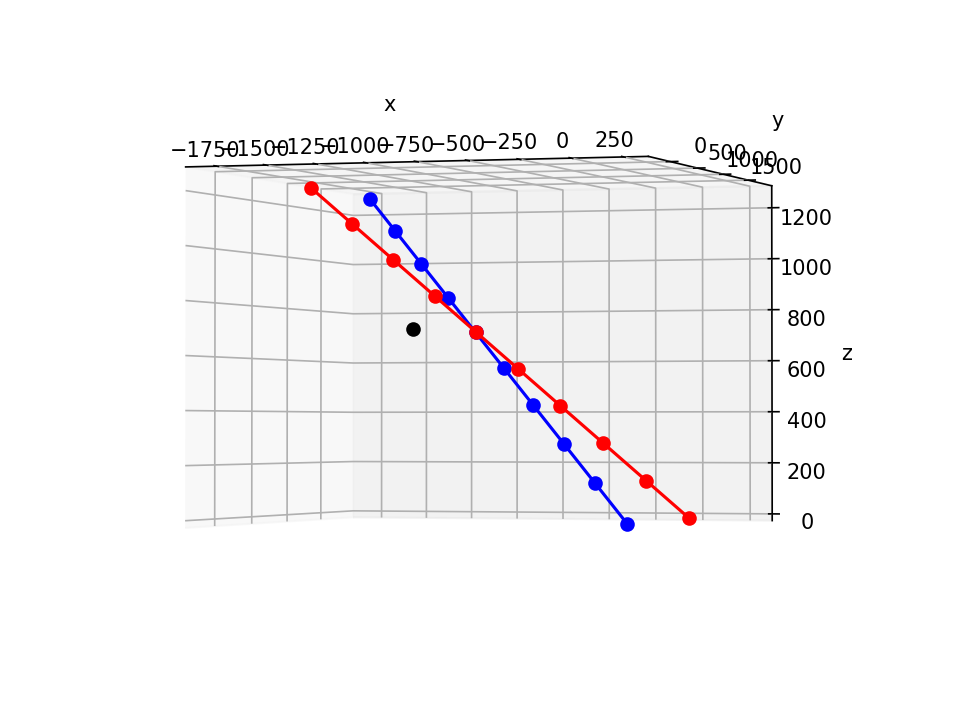

camera2 [-849.2242   891.2231   683.16235]


In [49]:
# カメラ2
Matrix2 = trans_matrix(cp_origin, cp_trans)
camera2 = camera(Matrix2, calib1, calib2, True)
print("camera2", camera2)

In [52]:
###### ペン先計算 ######
trans_focus1 = trans_point(Matrix1, focus1)
trans_focus2 = trans_point(Matrix2, focus2)

dir1 = camera1 - trans_focus1
dir2 = camera2 - trans_focus2

t = sympy.Symbol("t")
s = sympy.Symbol("s")

R = ((trans_focus1[0]+t*dir1[0]) - (trans_focus2[0]+s*dir2[0]))**2 + ((trans_focus1[1]+t*dir1[1]) - (trans_focus2[1]+s*dir2[1]))**2 + ((trans_focus1[2]+t*dir1[2]) - (trans_focus2[2]+s*dir2[2]))**2

dR_dt = sympy.diff(R, t)
dR_ds = sympy.diff(R, s)

ans = sympy.solve([dR_dt, dR_ds])
t_val = ans[t]
s_val = ans[s]
    
close1 = np.float32([trans_focus1[0]+t_val*dir1[0], trans_focus1[1]+t_val*dir1[1], trans_focus1[2]+t_val*dir1[2]])
close2 = np.float32([trans_focus2[0]+s_val*dir2[0], trans_focus2[1]+s_val*dir2[1], trans_focus2[2]+s_val*dir2[2]])

result = (close1[0] - close2[0])**2 + (close1[1] - close2[1])**2 + (close1[2] - close2[2])**2
print("R", result)

focus = (close1 + close2)/2
print("trans_focus1", trans_focus1)
print("trans_focus2", trans_focus2)
print("close1", close1)
print("close2", close2)
print("focus", focus)
print(ans)

R 32186.282073398354
trans_focus1 [ 6085.58283701 -1640.29915033     0.        ]
trans_focus2 [-12044.42574638  11892.54160092      0.        ]
close1 [ 273.453  -274.9427  579.7272]
close2 [ 299.5267  -237.63326  753.2623 ]
focus [ 286.48987 -256.28796  666.49475]
{s: 1.10261100417620, t: 0.831939509662428}


<IPython.core.display.Javascript object>


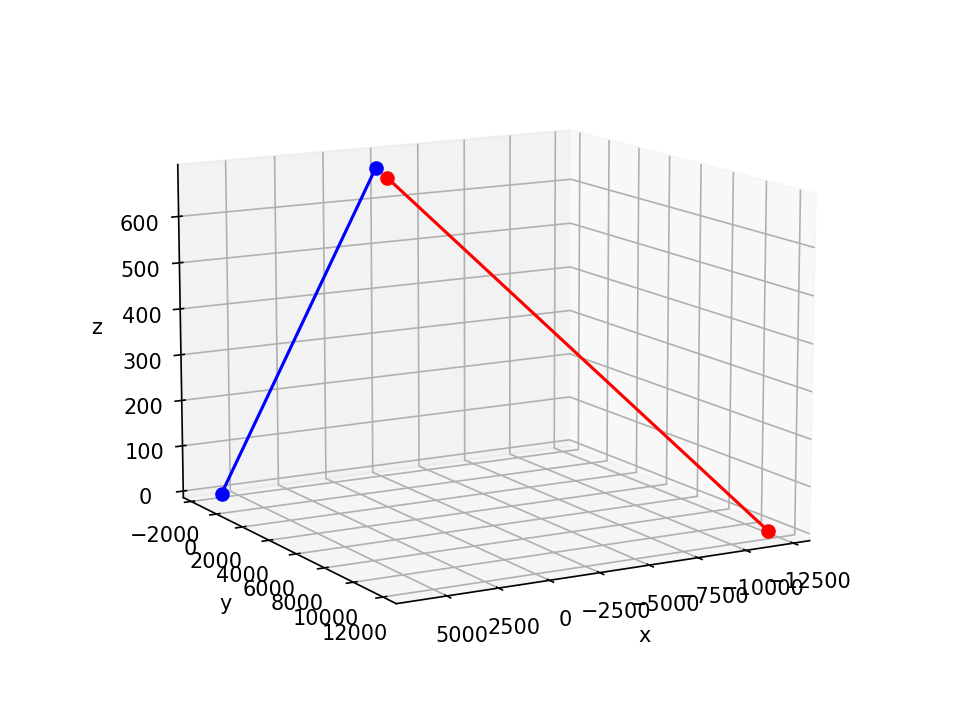

In [51]:
###### ペン先描画 ######
line1_x = [trans_focus1[0], camera1[0]]
line1_y = [trans_focus1[1], camera1[1]]
line1_z = [trans_focus1[2], camera1[2]]

line2_x = [trans_focus2[0], camera2[0]]
line2_y = [trans_focus2[1], camera2[1]]
line2_z = [trans_focus2[2], camera2[2]]

# プロット
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot(line1_x, line1_y, line1_z, "o-", color="Blue")
ax.plot(line2_x, line2_y, line2_z, "o-", color="Red")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()